In [28]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sbm import SBM
from infect import infect
from algos import binary_splitting, diag_splitting, Qtesting1, Qtesting2, Qtesting1_comm_aware, Qtesting2_comm_aware

In [36]:
def iter(N, M, q0, q1, p0, p1, time_steps, num_sims, method, dataset='sbm'):
    
    name = dataset + 'N' + str(N) + '_M' + str(M) + '_SIM' + str(num_sims) + '_step' + str(time_steps) + '_q0' + str(q0) + '_q1' + str(q1) + '_p0' + str(p0) + '_p1' + str(p1) + method + 'graphs.pkl'
    
    if not os.path.isfile(name):
        print('Generating synthetic dataset!')
        Gs = np.zeros((num_sims, N, N))
        Communities = {}
        data = {}
        Individuals = {}
        
        if dataset=='sbm':
            for i in range(num_sims):
                Gs[i] = SBM(N,M,q0,q1)
                ###################################################
                '''your code here'''
                communities = []
                approx_block_size = N // M
                
                for j in range(M):
                    community = list(range(j * approx_block_size, (j + 1) * approx_block_size))
                    communities.append(community)
                
                Communities[i] = communities
                Individuals[i] = infect(Gs[i], p0, p1, time_steps)
                ###################################################
        elif dataset=='iid':
            for i in range(num_sims):
                ###################################################
                '''your code here'''
                Individuals[i] = infect(np.ones((N, N)), p0, p1, time_steps)
                Communities[i] = [list(range(N))]
                ###################################################
        data['graph'] = Gs
        data['communities'] = Communities
        data['individuals'] = Individuals
        
        with open(name, 'wb') as infile:
            pickle.dump(data,infile) 
        print('Dataset done!')


    ###################################################
    '''your code for initialization parameters if needed''' 
    fraction_ppl = 0
    fraction_family = 0
    fraction_ppl_in_family = 0
    num_tests = {'binary': [], 'Q1': [], 'Q2': [], 'Q1_comm': [], 'Q2_comm': []}
    num_stages = {'binary': [], 'Q1': [], 'Q2': [], 'Q1_comm': [], 'Q2_comm': []}
    ###################################################
        
    if os.path.isfile(name):
        with open(name, 'rb') as infile:
            data = pickle.load(infile) 
        print('Data loaded!')
        
    for i in range(num_sims):
        if dataset=='synthetic':
            G = data['graph'][i]
            communities = data['communities'][i]
            individuals = data['individuals'][i]
        ###################################################
        '''your code to calculate the statistics here''' 
        infected_count = np.sum(individuals)
        community_sizes = [len(c) for c in communities]
        infected_in_communities = [np.sum(individuals[c]) for c in communities]
        
        fraction_ppl += infected_count / N
        fraction_family += np.mean([inf > 0 for inf in infected_in_communities])
        fraction_ppl_in_family += np.mean([inf / size for inf, size in zip(infected_in_communities, community_sizes)])
    
        ###################################################

        # interleave the individuals
        s = individuals.copy()
        np.random.shuffle(s)
        
        # Binary splitting
        numtests_bs, num_stages_bs, _ = binary_splitting(s)
        num_tests['binary'].append(numtests_bs)
        num_stages['binary'].append(num_stages_bs)
        
        # Qtesting1
        numtests_q1, num_stages_q1 = Qtesting1(s)
        num_tests['Q1'].append(numtests_q1)
        num_stages['Q1'].append(num_stages_q1)
        
        # Qtesting2
        numtests_q2, num_stages_q2 = Qtesting2(s)
        num_tests['Q2'].append(numtests_q2)
        num_stages['Q2'].append(num_stages_q2)
        
        # Community-aware Qtesting1
        numtests_q1_c, num_stages_q1_c = Qtesting1_comm_aware(individuals.copy(), communities)
        num_tests['Q1_comm'].append(numtests_q1_c)
        num_stages['Q1_comm'].append(num_stages_q1_c)
        
        # Community-aware Qtesting2
        numtests_q2_c, num_stages_q2_c = Qtesting2_comm_aware(individuals.copy(), communities)
        num_tests['Q2_comm'].append(numtests_q2_c)
        num_stages['Q2_comm'].append(num_stages_q2_c)

    ###################################################
    '''your code to calculate the statistics here''' 
    '''Do not forget to take the average'''
    fraction_ppl /= num_sims
    fraction_family /= num_sims
    fraction_ppl_in_family /= num_sims

    avg_num_tests = {k: np.mean(v) for k, v in num_tests.items()}
    avg_num_stages = {k: np.mean(v) for k, v in num_stages.items()}

    ###################################################
            

    return fraction_ppl, fraction_family, fraction_ppl_in_family, avg_num_tests, avg_num_stages

<div class="alert alert-warning">
<b>Task 1 </b> 
Plot how the fraction of infected people, the percentage of infected communities, and the average percentage of infected people in each community change with the each setting for the synthetic dataset described in the following table and comment on the results. Average over at least $100$ SBM network realization.     

</div>

| N | M | q0, q1 | p0 | p1 |time steps  |
|---|---|--------|----|----|------------|
|256| 16| (1,0)  |0.001|[0.05:1]|2|
|   | 16|(0.9, 0.1)  | 0.001| [0.05:1]|2     |
|   | 16 |(0.5, 0.2)  | 0.001| [0.05:1]|2     |

Consider $N=256$, and $M=16,64,128$. Use SBM with $q0=1$ and $q1=0$ to generate contact networks (disconnected cliques). For the infection model, use $p_0 = 0.001$ and $p_1 = [0.01:1]$ and the number of infection steps as $2$ . 
Average over 100 SBM network realizations.

<div class="alert alert-warning">
<b>Task 2 </b> 
Provide plots for i.i.d. infection probability that ranges from $p=0.01$ to $p=0.3$, and $N=256$.
Compare the performance of tests $T_1$, $T_2$, and binary output tests. Do you observe a consistent performance? Can you explain your results? 
    
</div>

<div class="alert alert-warning">
<b>Task 3 </b>  
Provide plots that compare the performance of various testing techniques on the Stochastic Block Model (SBM) using the settings outlined in Table 2 and on real data. You may explore additional settings that could reveal significant insights for your custom algorithms. Interpret and explain the results you obtain. Your plots should include: (i) a plot demonstrating how the performance of different testing schemes varies as the family sizes change, (ii)a plot demonstrating how the performance of different testing schemes varies as the infection probability changes and (iii) a plot illustrating how infections concentrate within families in the SBM.
</div>

| N | M | q0, q1 | p0 | p1 |time steps  |
|---|---|--------|----|----|------------|
|256| 16| (0.9,0.1)  |0.001|[0.05:1]|2|
|   | 64|(1, 0)  | 0.001| [0.05:1]|2     |
|   | 64|(0.9, 0.1)  | 0.001| [0.05:1]|2     |
|   | 64|(0.5, 0.2)  | 0.001| [0.05:1]|2     |
|   | 128 |(0.9, 0.1)  | 0.001| [0.05:1]|2     |


In [37]:
N = 256
M = 16
q0 = 0.5
q1 = 0.3
p0 = 0.001
p1 = 0.1
time_steps = 2
num_sims = 100
method = 'some_method'
dataset = 'sbm'

fraction_ppl, fraction_family, fraction_ppl_in_family, avg_num_tests, avg_num_stages = iter(N, M, q0, q1, p0, p1, time_steps, num_sims, method, dataset)

print(f'Fraction of people infected: {fraction_ppl}')
print(f'Fraction of families with at least one infected: {fraction_family}')
print(f'Average fraction of people infected in families: {fraction_ppl_in_family}')
print('Average number of tests:', avg_num_tests)
print('Average number of stages:', avg_num_stages)

def plot_iter_results():
    methods = ['binary', 'Q1', 'Q2', 'Q1_comm', 'Q2_comm']
    
    avg_tests = [avg_num_tests[m] for m in methods]
    avg_stages = [avg_num_stages[m] for m in methods]
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.bar(methods, avg_tests, color='skyblue')
    plt.xlabel('Testing Methods')
    plt.ylabel('Average Number of Tests')
    plt.title('Average Number of Tests for Different Methods')

    plt.subplot(1, 2, 2)
    plt.bar(methods, avg_stages, color='lightgreen')
    plt.xlabel('Testing Methods')
    plt.ylabel('Average Number of Stages')
    plt.title('Average Number of Stages for Different Methods')

    plt.tight_layout()
    plt.show()
    
plot_iter_results()

Data loaded!


UnboundLocalError: cannot access local variable 'individuals' where it is not associated with a value

In [38]:
# the simulation 
t = 10
fraction_infected_ppl = np.zeros(t)
fraction_infected_clc = np.zeros(t)
fraction_infected_family = np.zeros(t)
num_tests = np.zeros((t, 5))
num_stages = np.zeros((t, 5))

for j in range(1, t + 1):
    p1 = j / t
    fraction_ppl, fraction_clc, fraction_plp_in_clc, tests, stages = iter(N, M, q0, q1, p0, p1, time_steps, num_sims, method, dataset='sbm')
    num_tests[j - 1] = [tests['binary'], tests['Q1'], tests['Q2'], tests['Q1_comm'], tests['Q2_comm']]
    num_stages[j - 1] = [stages['binary'], stages['Q1'], stages['Q2'], stages['Q1_comm'], stages['Q2_comm']]
    fraction_infected_ppl[j - 1] = fraction_ppl
    fraction_infected_clc[j - 1] = fraction_clc
    fraction_infected_family[j - 1] = fraction_plp_in_clc
       

Data loaded!


UnboundLocalError: cannot access local variable 'individuals' where it is not associated with a value

In [39]:
p1s = np.arange(1,t+1)/t

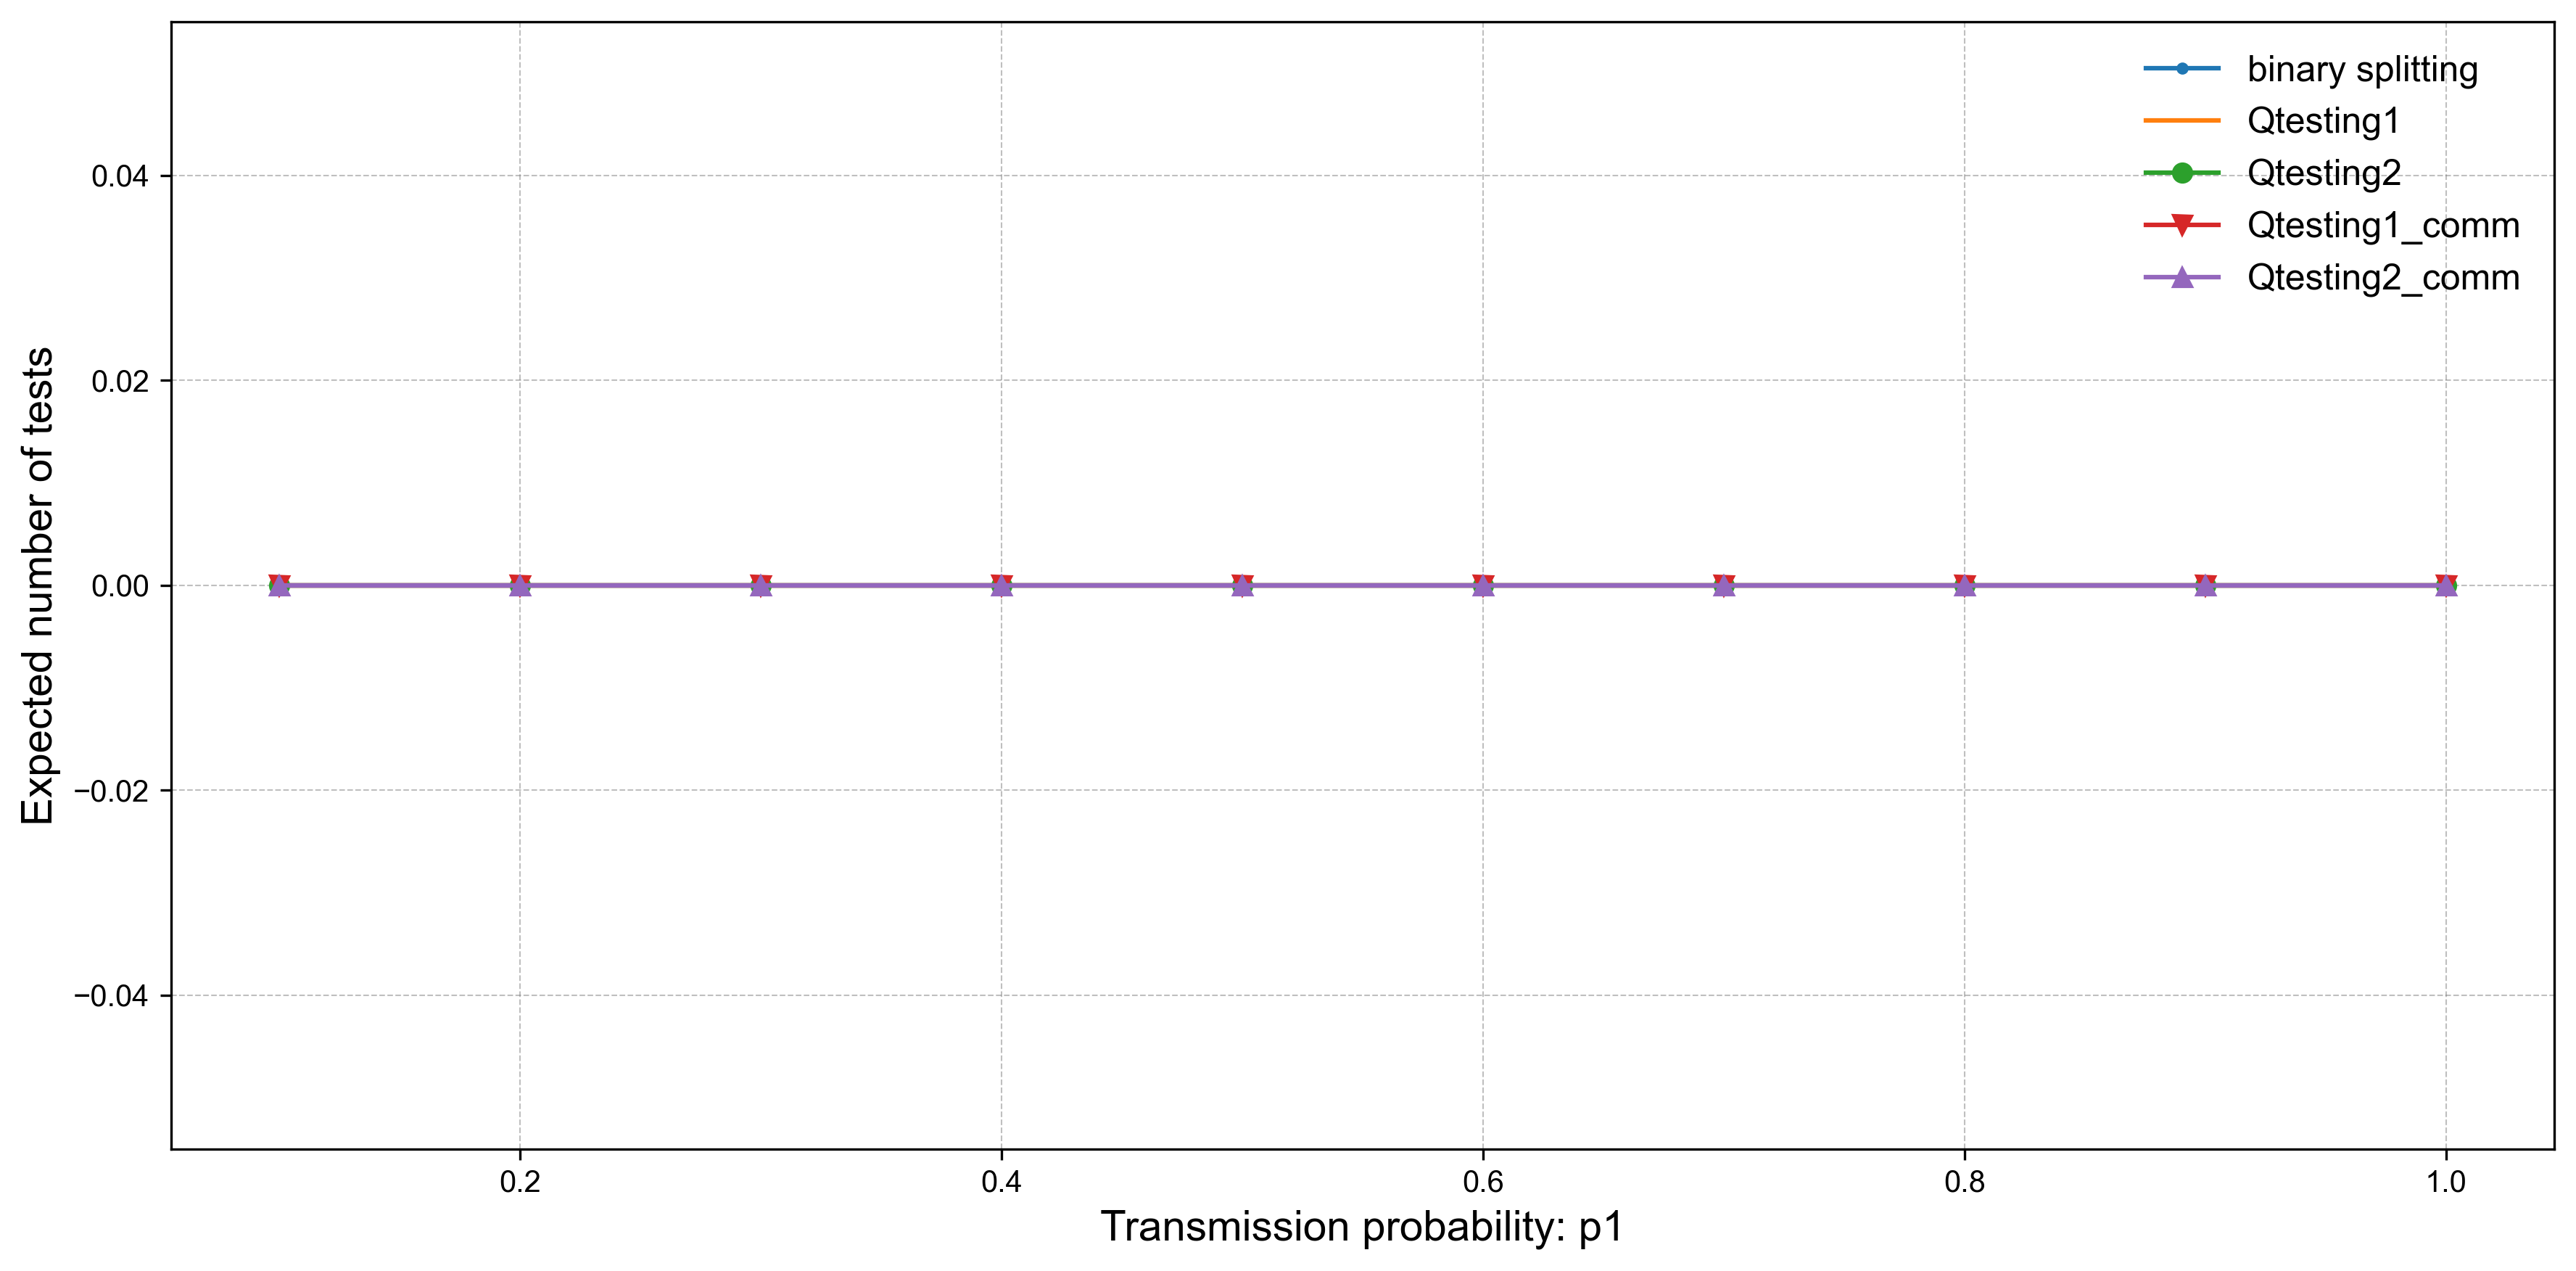

In [40]:
plt.figure(figsize=(12, 6), dpi=300)
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'sans-serif',
    'font.sans-serif': 'Arial',
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})
markers = ['.', ',', 'o', 'v', '^', '<', '>']
   

#########your code here###########
for i in range(5):
    plt.plot(p1s, num_tests[:, i], label=['binary splitting', 'Qtesting1', 'Qtesting2', 'Qtesting1_comm', 'Qtesting2_comm'][i], marker=markers[i])
    
plt.xlabel('Transmission probability: p1', fontsize=14)
plt.ylabel('Expected number of tests', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.legend(frameon=False, loc='best')
plt.tight_layout()
fig_name = f'RES_N{N}_M{M}_SIM{num_sims}_step{time_steps}_q0{q0}_q1{q1}_p0{p0}_{method}_GT.pdf'
plt.savefig(fig_name, format='pdf', bbox_inches='tight')
plt.show()

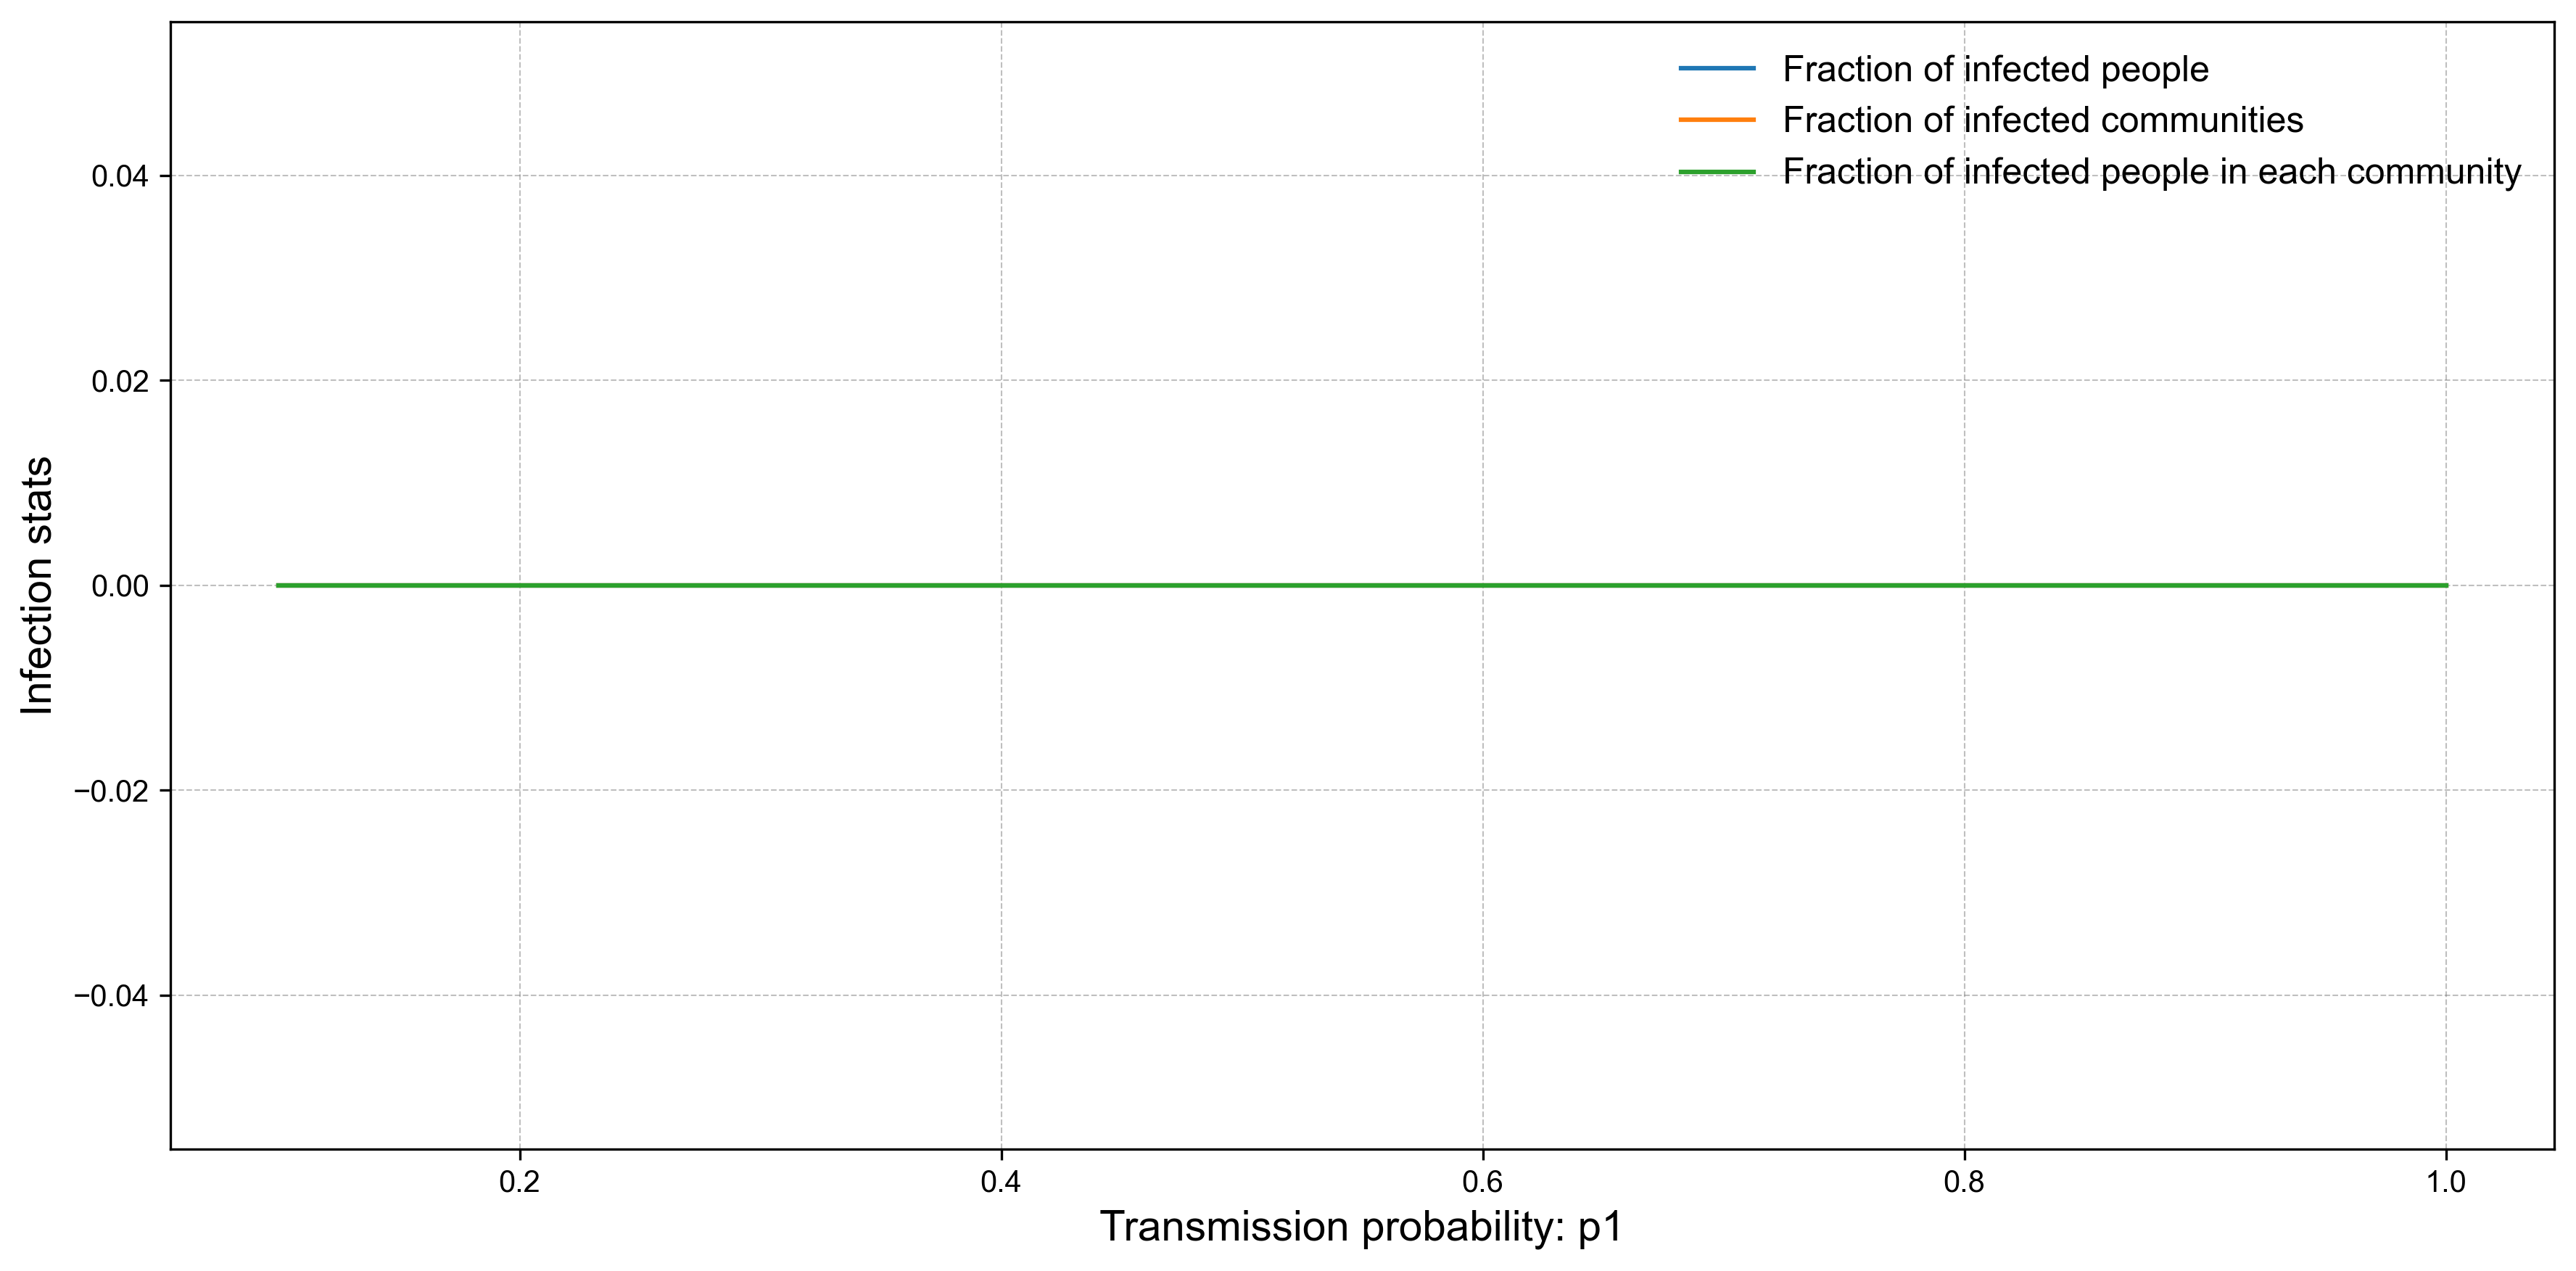

In [41]:
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(p1s, fraction_infected_ppl, label='Fraction of infected people')
plt.plot(p1s, fraction_infected_clc, label='Fraction of infected communities')
plt.plot(p1s, fraction_infected_family, label='Fraction of infected people in each community')
plt.xlabel('Transmission probability: p1', fontsize=14)
plt.ylabel('Infection stats', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.legend(frameon=False, loc='best')
plt.tight_layout()
fig_name = f'RES_N{N}_M{M}_SIM{num_sims}_step{time_steps}_q0{q0}_q1{q1}_p0{p0}_{method}_stats.pdf'
plt.savefig(fig_name, format='pdf', bbox_inches='tight')
plt.show()

In [42]:
# Unit tests for sbm.py, infect.py, and algos.py
def test_SBM():
    N = 100
    M = 5
    q0 = 0.8
    q1 = 0.2
    G = SBM(N, M, q0, q1)
    assert G.shape == (N, N), "SBM output has incorrect shape"
    assert np.all((G == 0) | (G == 1)), "SBM output is not a binary matrix"
    print("SBM test passed!")

def test_infect():
    N = 100
    G = np.ones((N, N))
    p0 = 0.1
    p1 = 0.05
    time_steps = 2
    individuals = infect(G, p0, p1, time_steps)
    assert len(individuals) == N, "Infect output has incorrect length"
    assert np.all((individuals == 0) | (individuals == 1)), "Infect output is not binary"
    print("Infect test passed!")

def test_algos():
    N = 100
    infected_individuals = np.zeros(N)
    infected_individuals[:10] = 1
    np.random.shuffle(infected_individuals)
    
    num_tests_bin, num_stages_bin = binary_splitting(infected_individuals)
    assert isinstance(num_tests_bin, int) and num_tests_bin > 0, "Binary splitting test count is invalid"
    assert isinstance(num_stages_bin, int) and num_stages_bin > 0, "Binary splitting stage count is invalid"
    
    num_tests_diag, num_stages_diag = diag_splitting(infected_individuals)
    assert isinstance(num_tests_diag, int) and num_tests_diag > 0, "Diagonal splitting test count is invalid"
    assert isinstance(num_stages_diag, int) and num_stages_diag > 0, "Diagonal splitting stage count is invalid"
    
    num_tests_q1, num_stages_q1 = Qtesting1(infected_individuals)
    assert isinstance(num_tests_q1, int) and num_tests_q1 > 0, "Qtesting1 test count is invalid"
    assert isinstance(num_stages_q1, int) and num_stages_q1 > 0, "Qtesting1 stage count is invalid"
    
    num_tests_q2, num_stages_q2 = Qtesting2(infected_individuals)
    assert isinstance(num_tests_q2, int) and num_tests_q2 > 0, "Qtesting2 test count is invalid"
    assert isinstance(num_stages_q2, int) and num_stages_q2 > 0, "Qtesting2 stage count is invalid"
    
    communities = [list(range(20)), list(range(20, 40)), list(range(40, 60)), list(range(60, 80)), list(range(80, 100))]
    
    num_tests_q1_c, num_stages_q1_c = Qtesting1_comm_aware(infected_individuals, communities)
    assert isinstance(num_tests_q1_c, int) and num_tests_q1_c > 0, "Qtesting1_comm test count is invalid"
    assert isinstance(num_stages_q1_c, int) and num_stages_q1_c > 0, "Qtesting1_comm stage count is invalid"
    
    num_tests_q2_c, num_stages_q2_c = Qtesting2_comm_aware(infected_individuals, communities)
    assert isinstance(num_tests_q2_c, int) and num_tests_q2_c > 0, "Qtesting2_comm test count is invalid"
    assert isinstance(num_stages_q2_c, int) and num_stages_q2_c > 0, "Qtesting2_comm stage count is invalid"
    
    print("All algorithm tests passed!")

# Run unit tests
test_SBM()
test_infect()
test_algos()

SBM test passed!
Infect test passed!


ValueError: too many values to unpack (expected 2)